In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

[1 dataset - diabetes](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)  
[2 dataset - cardio-vascular diseases](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea)  
[3 dataset - diabetes](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset)

### Functions

In [2]:
def plot_histograms(data: pd.DataFrame) -> None:
    """
    Print histograms with kernel density function
    of all numerical features.

    :param data: dataset
    :return: None
    """
    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    fig.suptitle('Params distribution', fontsize=16)
    axes = axes.flatten()
    cols = list(data.columns)
    if axes.shape[0] > len(cols):
        ax_del = axes.shape[0] - len(cols)
        for i in range(ax_del):
            fig.delaxes(axes[axes.shape[0] - i - 1])

    for i, col in enumerate(cols):
        hist = sns.histplot(
            data=data,
            x=col,
            bins=20,
            kde=True,
            ax=axes[i]
        )

In [3]:
def plot_boxplots(data: pd.DataFrame, 
                  title: str=None, 
                  cat_labels: pd.Series=None) -> None:
    """
    Print boxplots of all numerical features.

    :param data: dataset
    :param title: name of categorical feature
    :param cat_labels: categorical feature
    :return: None
    """
    fig, axes = plt.subplots(3, 3, figsize=(16, 11))
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    axes = axes.flatten()
    cols = list(data.columns)
    if axes.shape[0] > len(cols):
        ax_del = axes.shape[0] - len(cols)
        for i in range(ax_del):
            fig.delaxes(axes[axes.shape[0] - i - 1])

    for i, col in enumerate(cols):
        sns.boxplot(
            x=data[col], 
            y=cat_labels, 
            orient='h',
            width=0.8,
            ax=axes[i]
        )
        axes[i].set_ylabel(title)

In [4]:
def cols_null_percent(data: pd.DataFrame) -> pd.Series:
    """
    Create series with columns containing nans
    and plot heatmaps of data containing nans.

    :param data: dataset
    :return: series with percent of nan values
    """
    cols_null_percent = data.isnull().mean() * 100
    cols_with_null = cols_null_percent[
        cols_null_percent > 0
    ].sort_values(ascending=False)

    colors = ['blue', 'yellow'] 
    fig = plt.figure(figsize=(10, 6))
    sns.heatmap(
        data[cols_with_null.index].isnull(),
        cmap=sns.color_palette(colors),
    )

    return cols_with_null

In [5]:
def drop_na(data: pd.DataFrame, 
            tresh_col: float=0.7, 
            tresh_row: int=2) -> pd.DataFrame:
    """
    Drop nan values with a given treshold.

    :data: dataset
    :tresh_col: treshold value for columns drop
                in a range from 0 to 1
    :tresh_row: treshold value for rows drop
                in a range from 0 to length of dataframe
    :return: cleaned dataframe 
    """
    thresh = data.shape[0] * tresh_col
    data_cleaned = data.dropna(thresh=thresh, axis=1)

    m = data_cleaned.shape[1]
    data_cleaned = data_cleaned.dropna(
        how='any',
        thresh=m-tresh_row, 
        axis=0
    )

    return data_cleaned

In [6]:
def outliers_z_score_mod(data: pd.DataFrame,
                         feature: str, 
                         log_scale=False, 
                         left=3, 
                         right=3) -> tuple('int'):
    """
    Calculate outliers based on the 3-sigma rule.

    :param data: dataset
    :param feature: numerical feature
    :param log_scale: log transformation of the feature
    :left: size of the left tail
    :right: size of the right tail
    :return: number of outliers and remain data
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left*sigma
    upper_bound = mu + right*sigma
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]

    return outliers, cleaned

In [7]:
def get_table_outliers(data: pd.DataFrame, 
                       columns: list['str'], 
                       log_scales: list['bool']) -> pd.DataFrame:
    """
    Create dataframe with number and proportion of
    outliers based on the 3-sigma rule and remain data.

    :param data: dataset
    :param columns: numerical feature
    :param log_scale: log transformation of the feature
    :return: dataframe
    """
    table = pd.DataFrame(index=[
        'Outliers number (3-sigm rule)', 
        'Percent of outliers (%)',
        'Remain number of rows'
    ])

    for col, log in zip(columns, log_scales):
        outliers, cleaned = outliers_z_score_mod(
            data, 
            col, 
            log_scale=log
        )
        table[col] = [
            outliers.shape[0],
            round(outliers.shape[0]/cleaned.shape[0] * 100, 2),
            cleaned.shape[0]
        ]

    return table.transpose()

In [8]:
def pairplot_with_line(data: pd.DataFrame) -> None:
    """
    Plot pairplots and pairplots with regression line.

    :param data: dataset
    :return: None
    """
    g = sns.PairGrid(data, diag_sharey=False)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.regplot, line_kws={'color': 'darkred'})
    g.map_diag(sns.kdeplot)

In [9]:
def plot_corr(data: pd.DataFrame) -> None:
    """
    Plot heatmap of correlations.

    :param data: dataset
    :return: None
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        data.corr(),
        cmap='PiYG', 
        annot=True,
        vmin=-1,
        vmax=1
    )
    ax.xaxis.set_tick_params(rotation=30)
    ax.yaxis.set_tick_params(rotation=30)

In [10]:
def plot_percentbars(data: pd.DataFrame, 
                     group_feature: str, 
                     xticklabels: list['str']) -> None:
    """
    Plot percentage barplot to evaluate
    dependances with diabetes.

    :param data: dataset
    :param group_feature: categorical feature
    :xticklabels: x-ticks labels
    :return: None
    """
    df = (data.groupby([group_feature])['Outcome']
          .value_counts(normalize=True)
          .rename('percentage')
          .mul(100)
          .reset_index()
    )
    categories = df['Outcome'].apply(lambda x: 'yes' if x == 1 else 'no')

    fig = plt.figure(figsize=(9, 6))
    barplot = sns.barplot(
        data=df,
        x=group_feature,
        y='percentage',
        hue=categories
    )
    barplot.set_title(f'Diabetes depending on {group_feature}')
    barplot.set_xlabel(group_feature)
    barplot.set_xticklabels(xticklabels)
    barplot.legend(title="Diabetes")

In [11]:
def get_age_cat(age: float) -> int:
    """
    Create age category by dividing by quartiles.

    :param age: age float
    :return: age category
    """
    if age < 24:
        return 0
    elif 24 <= age < 29:
        return 1
    elif 29 <= age < 41:
        return 2
    else:
        return 3

In [12]:
def get_age_cat_13(age: float) -> int:
    """
    Create age category by dividing into 13 intervals
    by 5-year periods.

    :param age: age float
    :return: age category
    """
    if 18 <= age <= 24:
        return 1
    elif 25 <= age <= 29:
        return 2
    elif 30 <= age <= 34:
        return 3
    elif 35 <= age <= 39:
        return 4
    elif 40 <= age <= 44:
        return 5
    elif 45 <= age <= 49:
        return 6
    elif 50 <= age <= 54:
        return 7
    elif 55 <= age <= 59:
        return 8
    elif 60 <= age <= 64:
        return 9
    elif 65 <= age <= 69:
        return 10
    elif 70 <= age <= 74:
        return 11
    elif 75 <= age <= 79:
        return 12
    else:
        return 13

In [13]:
def get_obesity_stage(bmi: float) -> int:
    """
    Create bmi category.

    :param bmi: bmi float
    :return: obesity stage
    """
    if bmi <= 29:
        return 0
    elif 30 <= bmi <= 34:
        return 1
    elif 35 <= bmi <= 39:
        return 2
    else:
        return 3

___

### First dataset

In [14]:
diabetes = pd.read_csv('diabetes.csv')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [15]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
diabetes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [17]:
diabetes.duplicated().sum()

0

Дубликатов нет.  
Очевидных пропусков нет, однако минимальное значение в столбцах Glucose, BloodPressure, SkinThickness, Insulin и BMI равно 0, что является невозможным, поэтому будем считать нулевые значения в этих столбцах пропусками.

In [18]:
# Список столбцов, где минимальное значение равно 0
cols_with_0 = [
    'Glucose', 
    'BloodPressure', 
    'SkinThickness', 
    'Insulin', 
    'BMI'
]

# Замена нулевых значений в каждом столбце на nan
for col in cols_with_0:
    diabetes[col] = diabetes[col].apply(lambda x: np.nan if x == 0 else x)

Insulin          48.697917
SkinThickness    29.557292
BloodPressure     4.557292
BMI               1.432292
Glucose           0.651042
dtype: float64

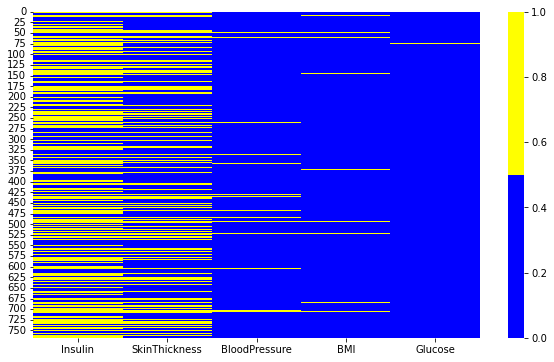

In [19]:
# Проверка на пропуски
cols_null = cols_null_percent(data=diabetes)
cols_null

Половина значений в столбце Insulin отсутсвует.  
Есть наблюдения, в которых отсутствуют значения сразу нескольких параметров.  
Удалим записи, в которых отсуствует более 30% данных и наблюдения, в которых отсутствует более 2 признаков.

In [20]:
diabetes_cleaned = drop_na(diabetes)

#### Обработка выбросов 

In [21]:
diabetes_cleaned.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,761.0,3.840999,3.370491,0.000,1.000,3.000,6.000,17.00
Glucose,756.0,121.932540,30.533481,44.000,100.000,117.000,141.000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.000,72.000,80.000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.000,29.000,36.000,99.00
BMI,757.0,32.457464,6.924988,18.200,27.500,32.300,36.600,67.10
DiabetesPedigreeFunction,761.0,0.474126,0.331947,0.078,0.244,0.378,0.629,2.42
Age,761.0,33.323259,11.779469,21.000,24.000,29.000,41.000,81.00
Outcome,761.0,0.350854,0.477551,0.000,0.000,0.000,1.000,1.00


In [22]:
# Диастолическое давление ниже 40 мм рт.ст. крайне маловероятно для
# человека, не находящегося в реанимации, поэтому удаляем такие наблюдения
diabetes_cleaned[diabetes_cleaned['BloodPressure'] <= 40]

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,43.1,2.288,33,1
18,1,103.0,30.0,38.0,43.3,0.183,33,0
125,1,88.0,30.0,42.0,55.0,0.496,26,1
597,1,89.0,24.0,19.0,27.8,0.559,21,0
599,1,109.0,38.0,18.0,23.1,0.407,26,0


In [23]:
diabetes_cleaned = diabetes_cleaned[diabetes_cleaned['BloodPressure'] > 40]

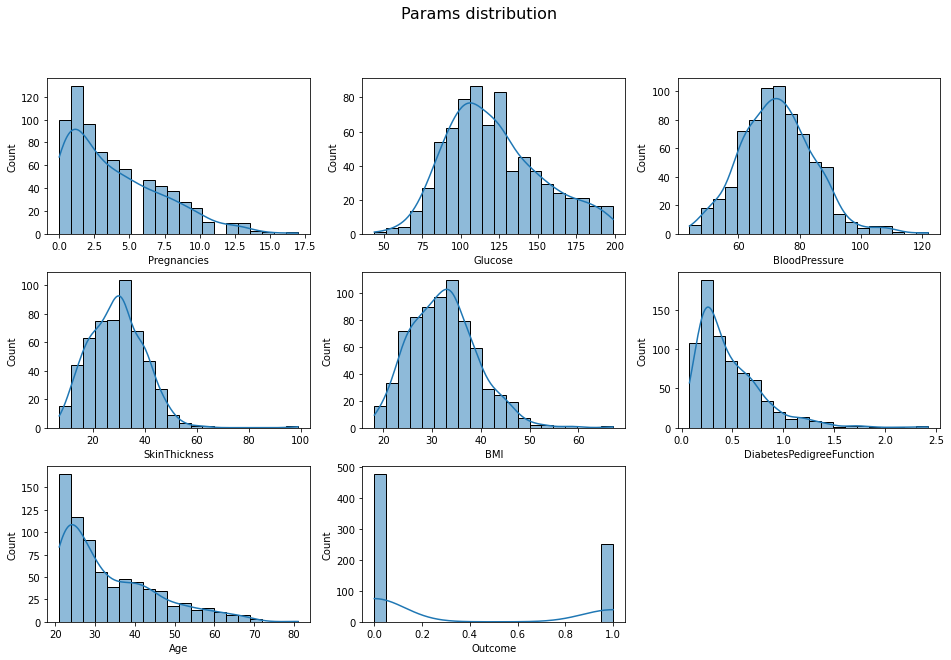

In [24]:
# Строим гистограммы распределения с ядерной оценкой плотности
plot_histograms(data=diabetes_cleaned)

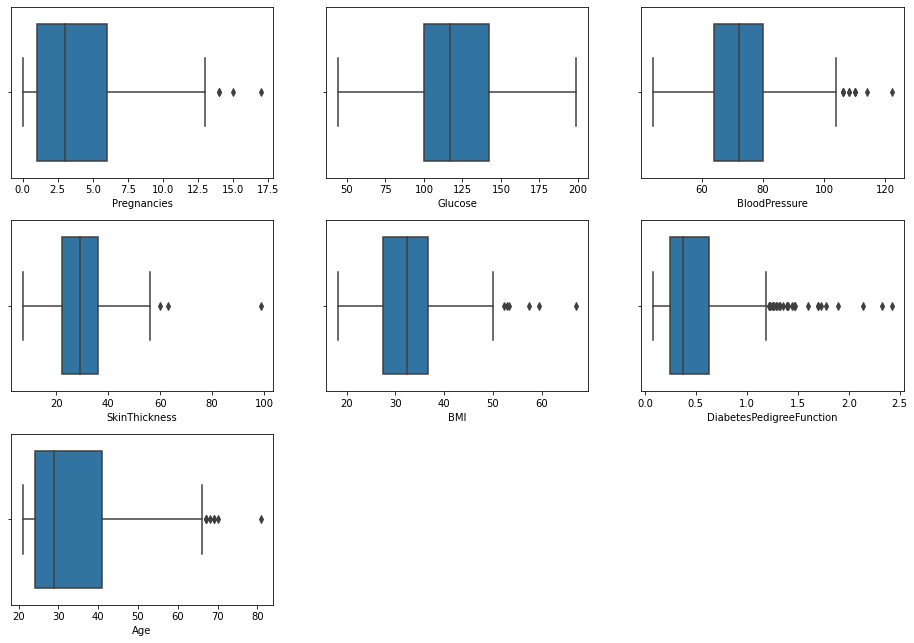

In [25]:
# Строим ящики с усами, исключив бинарную переменную
plot_boxplots(data=diabetes_cleaned.iloc[:, 0:7])

Переменная BloodPressure и Glucose близки к нормальному распределению. Распределения остальных переменных смещены вправо, некоторые напоминают логнормальное распределение.  
По боксплотам видны выбросы, однако с медицинской точки зрения такие наблюдения имеют право на существование. Методом 3-х сигм выбросов для этой выборки выявляется немного. На данном этапе не будем их удалять, поскольку предстоит объединение с другим датасетом, где эти значения уже могут перестать считаться выбросами.

In [26]:
outliers_table  = get_table_outliers(
    data=diabetes_cleaned.iloc[:, 0:8],
    columns=diabetes_cleaned.columns.tolist(),
    log_scales=[False, False, False, True, True, True, True]
)
display(outliers_table)

,Outliers number (3-sigm rule),Percent of outliers (%),Remain number of rows
Pregnancies,4.0,0.55,724.0
Glucose,0.0,0.00,723.0
BloodPressure,5.0,0.69,723.0
SkinThickness,5.0,0.95,529.0
BMI,1.0,0.14,723.0
DiabetesPedigreeFunction,0.0,0.00,728.0
Age,0.0,0.00,728.0


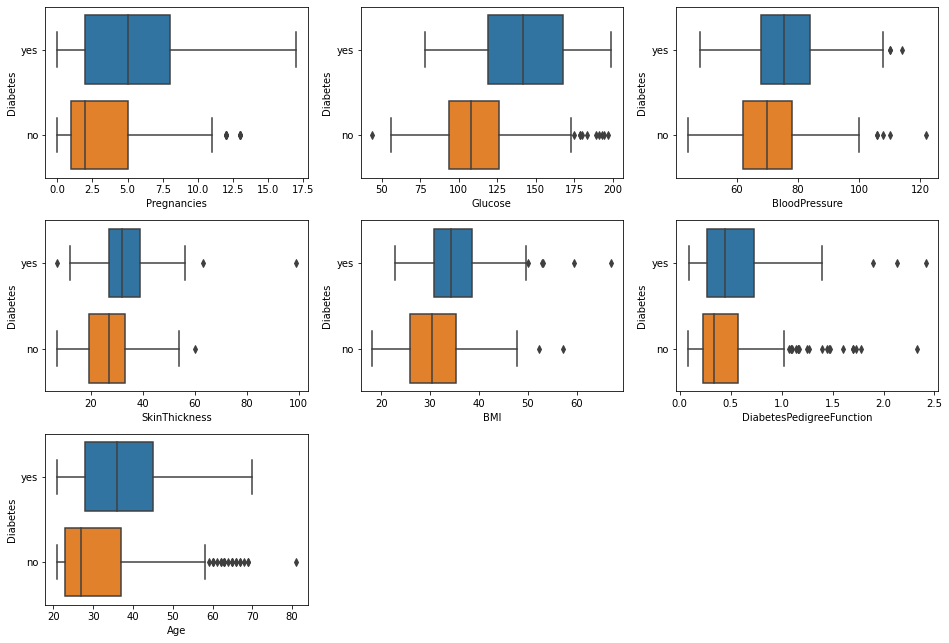

In [27]:
# Посмотрим на различия числовых параметров от наличия диабета
diabetes_cat = diabetes_cleaned['Outcome'].apply(
    lambda x: 'yes' if x == 1 else 'no'
)
plot_boxplots(
    data=diabetes_cleaned.iloc[:, 0:7], 
    title='Diabetes', 
    cat_labels=diabetes_cat
)

**Вывод:** Уровень всех параметров несколько выше в группе пациентов с диабетом. Для ряда показателей взаимосвязь очевидна (глюкоза, возраст, индекс массы тела, толщина подкожной складки, функция родословной), зависимость исходит из определения диабета и его факторов риска.  
Влияние артериального давления и количества беременностей на развитие диабета требует уточнения.  
Для этого посмотрим на наличие зависимостей между входными признаками.

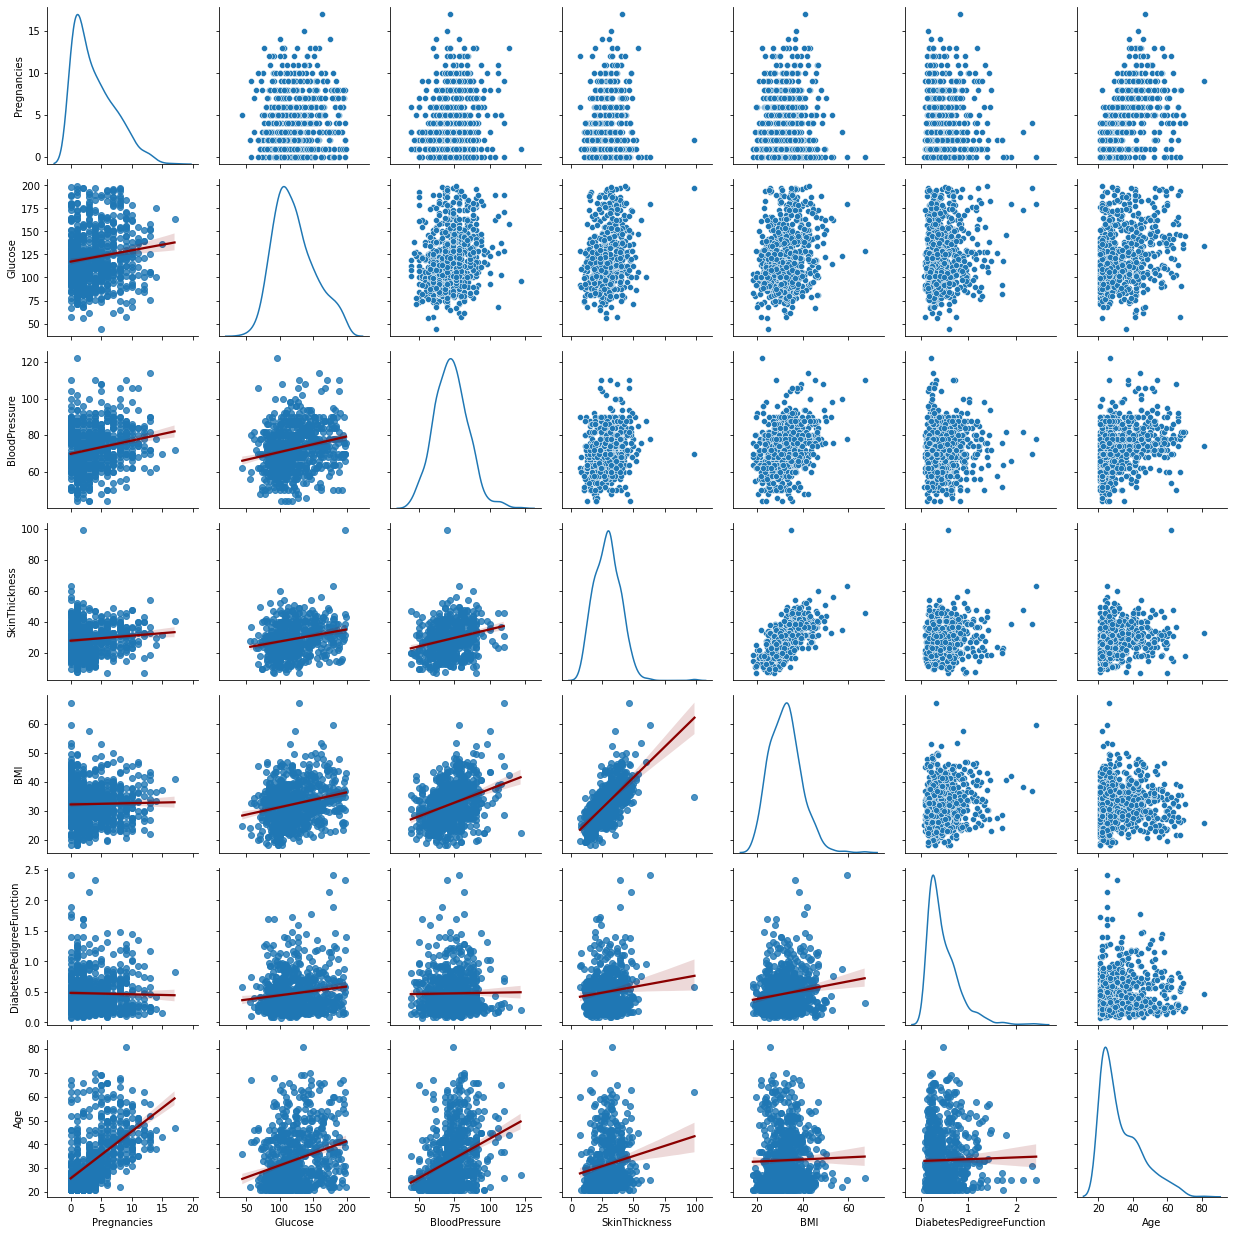

In [28]:
pairplot_with_line(data=diabetes_cleaned.iloc[:, 0:7])

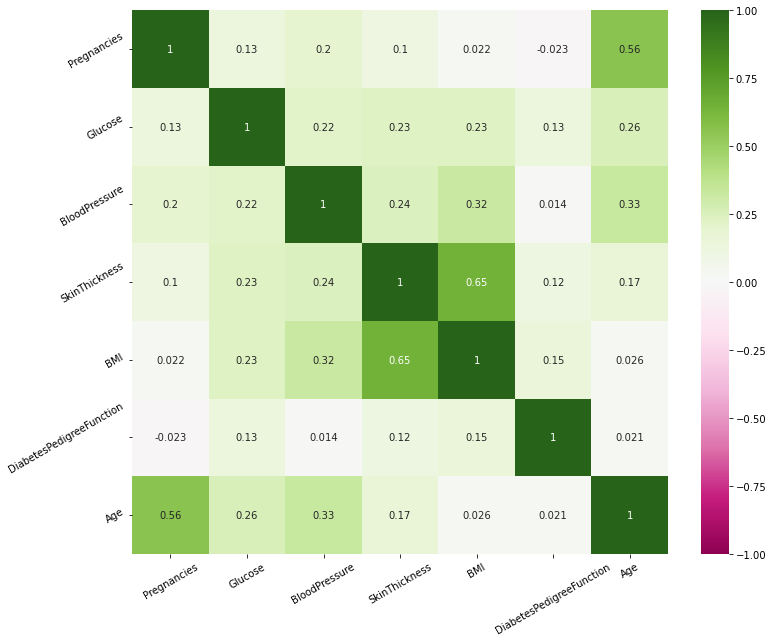

In [29]:
plot_corr(diabetes_cleaned.iloc[:, :7])

**Вывод**: Имеется взаимосвязь средней силы между количеством беременностей и возрастом, между толщиной кожной складки и индексом массы тела, более слабая между артериальным давлением и возрастом, глюкозой и возрастом.  
Чтобы оценить взаимосвязь признаков с наличием диабета независимо от возраста, необходимо провести коррекцию по возрасту - зафиксировать значение этого параметра. Для этого преобразуем возраст в категориальный признак и посмотрим взаимосвязь признаков в каждой возрастной группе.  
Для получения групп одинакового размера разбивку возраста проводим по квартилям.  

In [30]:
diabetes_cleaned['age_cat'] = diabetes_cleaned['Age'].apply(get_age_cat)

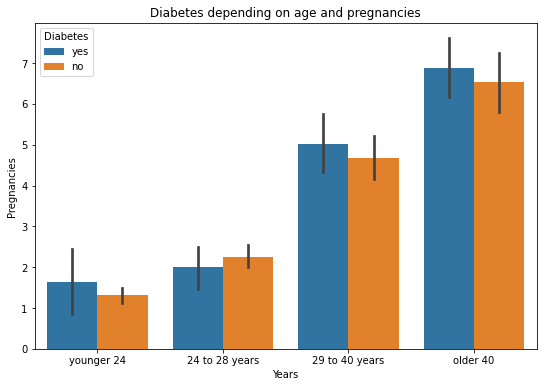

In [31]:
fig = plt.figure(figsize=(9, 6))
barplot = sns.barplot(
    data=diabetes_cleaned,
    x='age_cat',
    y='Pregnancies',
    hue=diabetes_cat
)
barplot.set_title('Diabetes depending on age and pregnancies')
barplot.set_xlabel('Years')
barplot.set_xticklabels([
    'younger 24', 
    '24 to 28 years', 
    '29 to 40 years', 
    'older 40'
])
barplot.legend(title="Diabetes");

Таким образом, в каждой возрастной группе количество беременностей сопоставимо у пациентов с диабетом и без него (для достоверной оценки требуется вычисление статистических показателей).  
  
В группе молодых пациентов уровень диастолического давления несколько выше у пациентов с диабетом, в остальных трех возрастных группах давление не различается.

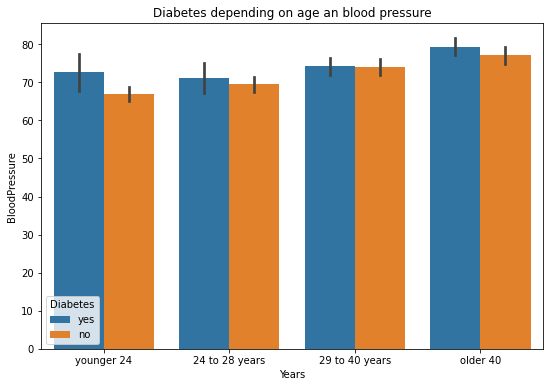

In [32]:
fig = plt.figure(figsize=(9, 6))
barplot = sns.barplot(
    data=diabetes_cleaned,
    x='age_cat',
    y='BloodPressure',
    hue=diabetes_cat
)
barplot.set_title('Diabetes depending on age an blood pressure')
barplot.set_xlabel('Years')
barplot.set_xticklabels([
    'younger 24', 
    '24 to 28 years', 
    '29 to 40 years', 
    'older 40'
])
barplot.legend(title="Diabetes");

### Second dataset

In [33]:
card = pd.read_csv('test.csv')
card

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,3390,43,2.0,M,YES,35.0,0.0,0,0,0,207.0,117.0,65.0,24.42,60.0,100.0
1,3391,56,3.0,F,NO,0.0,0.0,0,0,0,192.0,122.0,82.5,28.61,68.0,58.0
2,3392,58,1.0,F,YES,20.0,0.0,0,1,0,260.0,180.0,100.0,25.56,100.0,NaN
3,3393,47,3.0,F,NO,0.0,0.0,0,0,0,231.0,102.5,66.0,23.40,70.0,78.0
4,3394,44,1.0,M,NO,0.0,0.0,0,0,0,160.0,118.5,87.0,25.81,54.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,4233,46,3.0,F,NO,0.0,0.0,0,0,0,277.0,122.5,77.5,27.42,63.0,77.0
844,4234,58,2.0,F,NO,0.0,0.0,0,0,0,190.0,132.0,67.0,23.08,65.0,70.0
845,4235,55,1.0,M,NO,0.0,0.0,0,0,0,199.0,134.0,80.0,26.41,120.0,NaN
846,4236,45,3.0,F,NO,0.0,0.0,0,1,0,231.0,157.5,104.5,22.86,75.0,92.0


In [34]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               848 non-null    int64  
 1   age              848 non-null    int64  
 2   education        830 non-null    float64
 3   sex              848 non-null    object 
 4   is_smoking       848 non-null    object 
 5   cigsPerDay       841 non-null    float64
 6   BPMeds           839 non-null    float64
 7   prevalentStroke  848 non-null    int64  
 8   prevalentHyp     848 non-null    int64  
 9   diabetes         848 non-null    int64  
 10  totChol          836 non-null    float64
 11  sysBP            848 non-null    float64
 12  diaBP            848 non-null    float64
 13  BMI              843 non-null    float64
 14  heartRate        848 non-null    float64
 15  glucose          764 non-null    float64
dtypes: float64(9), int64(5), object(2)
memory usage: 106.1+ KB


In [35]:
# Приводим переменные без пропусков, которые не имеют смысла 
# в дробном выражении, к целочисленному типу
card['sysBP'] = card['sysBP'].astype('int64')
card['diaBP'] = card['diaBP'].astype('int64')
card['heartRate'] = card['heartRate'].astype('int64')

In [36]:
card.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,848.0,3813.500000,244.940809,3390.00,3601.750,3813.5,4025.250,4237.0
age,848.0,49.755896,8.491712,33.00,43.000,49.0,56.000,69.0
education,830.0,2.010843,1.022605,1.00,1.000,2.0,3.000,4.0
cigsPerDay,841.0,8.737218,12.086441,0.00,0.000,0.0,20.000,60.0
BPMeds,839.0,0.028605,0.166794,0.00,0.000,0.0,0.000,1.0
prevalentStroke,848.0,0.003538,0.059409,0.00,0.000,0.0,0.000,1.0
prevalentHyp,848.0,0.291274,0.454617,0.00,0.000,0.0,1.000,1.0
diabetes,848.0,0.025943,0.159060,0.00,0.000,0.0,0.000,1.0
totChol,836.0,235.307416,41.848200,140.00,205.000,232.0,260.000,405.0
sysBP,848.0,131.255896,20.978470,92.00,116.000,127.0,142.000,206.0


In [37]:
card.duplicated().sum()

0

glucose       9.905660
education     2.122642
totChol       1.415094
BPMeds        1.061321
cigsPerDay    0.825472
BMI           0.589623
dtype: float64

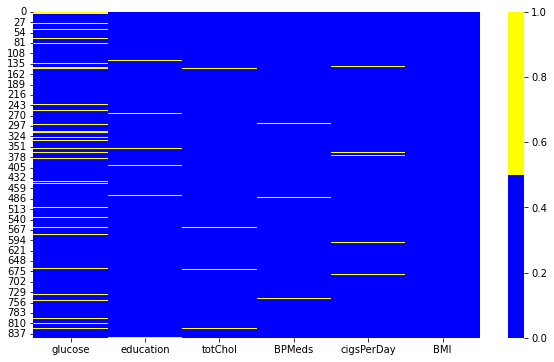

In [38]:
cols_null = cols_null_percent(data=card)
cols_null

Дубликотов нет.  
Пропусков не много, оставляем, поскольку эти признаки (с пропусками) использованы не будут.  
Аномалий с медицинской точки зрения нет.

In [39]:
# Переименуем совпадающие столбцы 2-го датасета
cols_same = {
    'age': 'Age',
    'diabetes': 'Outcome',
    'diaBP': 'BloodPressure',
    'glucose': 'Glucose'
}
card = card.rename(columns=cols_same)

# Для дальнейшего объединения датасетов
# Преобразуем категории переменной sex
card['sex'] = card['sex'].apply(lambda x: 0 if x == 'F' else 1)

# Добавим в первый датасет столбец с полом (все женщины)
diabetes_cleaned['sex'] = 0

In [40]:
#  Объединяем датасеты по совпадающим столбцам
diabetes_2 = pd.concat(
    [diabetes_cleaned, card],
    ignore_index=True,
    join='inner'
)
diabetes_2

,Glucose,BloodPressure,BMI,Age,Outcome,sex
0,148.0,72.0,33.60,50,1,0
1,85.0,66.0,26.60,31,0,0
2,183.0,64.0,23.30,32,1,0
3,89.0,66.0,28.10,21,0,0
4,116.0,74.0,25.60,30,0,0
...,...,...,...,...,...,...
1571,77.0,77.0,27.42,46,0,0
1572,70.0,67.0,23.08,58,0,0
1573,NaN,80.0,26.41,55,0,1
1574,92.0,104.0,22.86,45,0,0


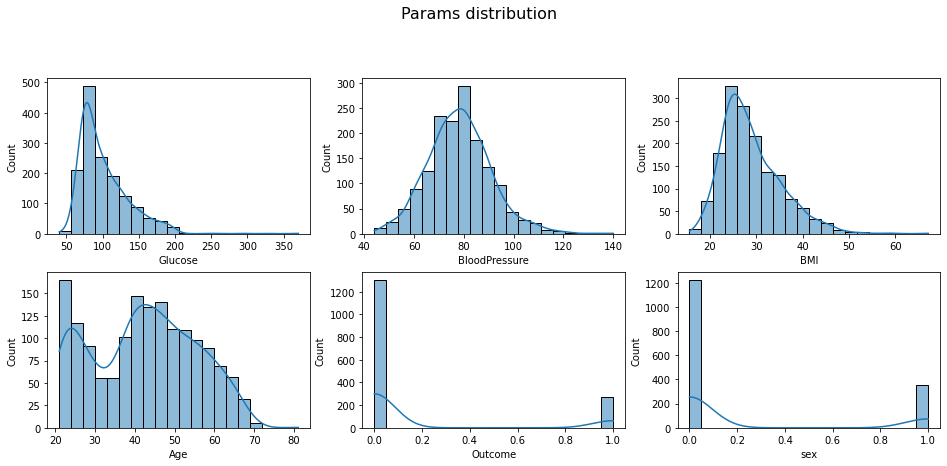

In [41]:
# Строим гистограммы распределения с ядерной оценкой плотности
plot_histograms(data=diabetes_2)

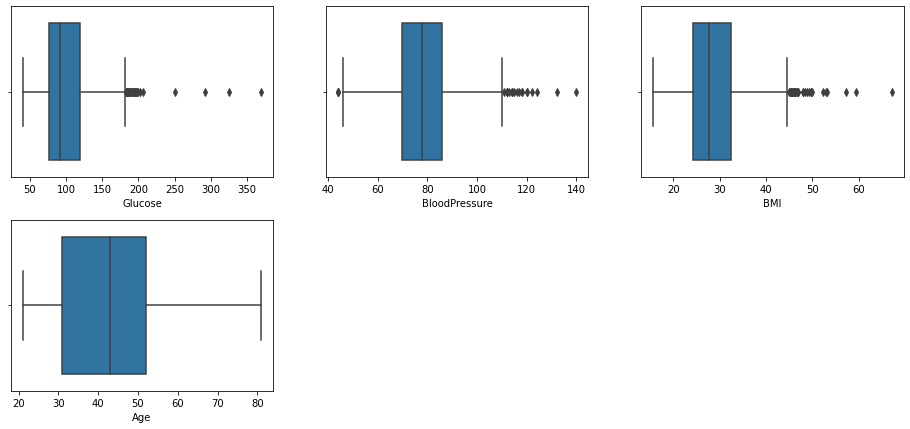

In [42]:
# Строим ящики с усами, исключив бинарные переменные
plot_boxplots(data=diabetes_2.iloc[:, 0:4])

In [43]:
outliers_table  = get_table_outliers(
    data=diabetes_2.iloc[:, 0:5],
    columns=diabetes_2.columns.tolist(),
    log_scales=[True, False, True, True]
)
display(outliers_table)

,Outliers number (3-sigm rule),Percent of outliers (%),Remain number of rows
Glucose,4.0,0.27,1483.0
BloodPressure,9.0,0.57,1567.0
BMI,4.0,0.26,1563.0
Age,0.0,0.00,1576.0


Переменная BloodPressure, по-прежнему близка к нормальному распределению. Распределения остальных переменных смещены вправо. Распределение возраста стало двугорбым, поскольку объединили две выборки сопоставимых размеров с разными модами (близкой к 20 и близкой к 40).  
Выбросов незначительное количество, удалим их из столбцов, которые будем использовать для дальнейшего объединения с 3-им датасетом.

In [44]:
outliers, diabetes_2 = outliers_z_score_mod(
    data=diabetes_2,
    feature='BloodPressure',
    log_scale=False
)
outliers, diabetes_2 = outliers_z_score_mod(
    data=diabetes_2,
    feature='BMI',
    log_scale=True
)

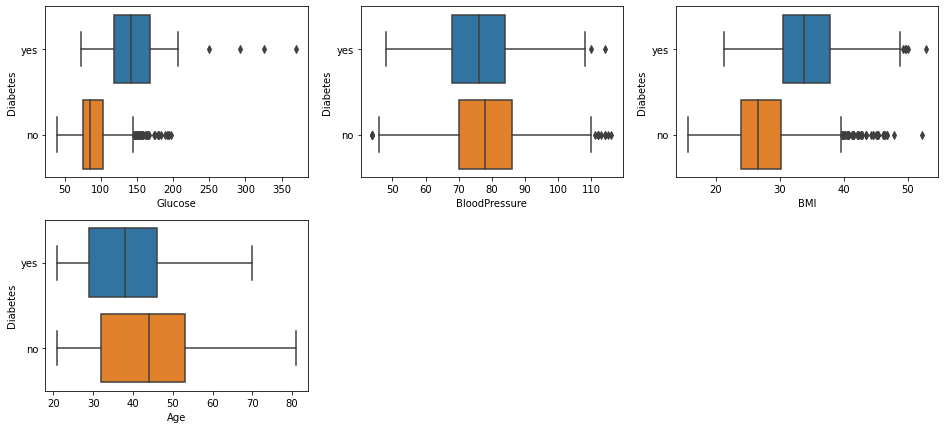

In [45]:
# Посмотрим на различия числовых параметров от наличия диабета
diabetes_cat = diabetes_2['Outcome'].apply(
    lambda x: 'yes' if x == 1 else 'no'
)
plot_boxplots(
    data=diabetes_2.iloc[:, 0:4], 
    title='Diabetes', 
    cat_labels=diabetes_cat
)

В группе диабета возраст стал ниже, что не совсем корректно и может быть связано с несбалансированным датасетом.  
Диастолическое давление также стало ниже у пациентов с диабетом.  
Индекс массы тела по-прежнему выше в группе диабета.

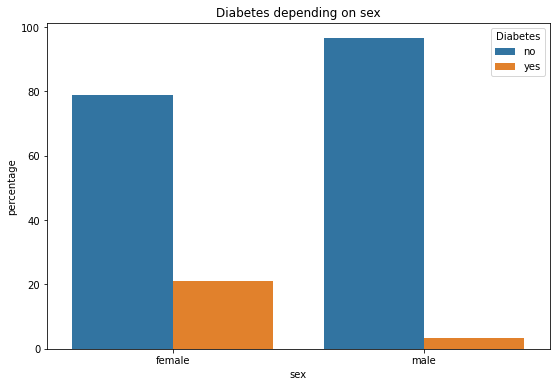

In [46]:
# Визуализируем зависимость категориального параметра от диабета
# Для этого группируем исход по полу
plot_percentbars(
    data=diabetes_2,
    group_feature='sex',
    xticklabels=['female', 'male']
)

В данном датасете у женщин диабет выявляется чаще.

### Third dataset 

In [47]:
diabetes_3 = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
diabetes_3

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [48]:
diabetes_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [49]:
diabetes_3.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0
HighBP,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
HighChol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
CholCheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
BMI,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
Smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
Stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
PhysActivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
Fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


In [50]:
sum_dupl = diabetes_3.duplicated().sum()
perc_dupl = diabetes_3.duplicated().sum()/diabetes_3.shape[0] * 100
print('Количество дубликатов в 3-ем датасете: ', sum_dupl)
print(f'Процент дубликатов в 3-ем датасете: {round(perc_dupl, 2)}%')

Количество дубликатов в 3-ем датасете:  23899
Процент дубликатов в 3-ем датасете: 9.42%


In [51]:
# Удаляем дубликаты
diabetes_3 = diabetes_3.drop_duplicates()

In [52]:
diabetes_3.isnull().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Пропусков нет.  
В 3 датасете все переменные категориальные.  
Для корректного объединения с предыдущими датасетами, необходимо в них численные параметры (возраст, диастолическое давление) привести к категориальным.  

In [53]:
# Создаем бинарный параметр диастолического давления 
diabetes_2['HighBP'] = diabetes_2['BloodPressure'].apply(
    lambda x: 0 if x < 90 else 1
)

# Преобразуем возраст в 13 категорий
diabetes_2['Age_cat'] = diabetes_2['Age'].apply(get_age_cat_13)

# В 3-ем датасете отдельно закодирован преддиабет, преобразуем столбец
# с исходом, будем считать наличие преддиабета как исход
diabetes_3['Outcome'] = diabetes_3['Diabetes_012'].apply(
    lambda x: 0 if x == 0 else 1
)

# Переименуем совпадающие столбцы 3-го датасета
cols_same = {
    'Sex': 'sex',
    'Age': 'Age_cat'
}
diabetes_3 = diabetes_3.rename(columns=cols_same)

In [54]:
#  Объединяем датасеты по совпадающим столбцам
diabetes_gen = pd.concat(
    [diabetes_2, diabetes_3],
    ignore_index=True,
    join='inner'
)
diabetes_gen

,BMI,Outcome,sex,HighBP,Age_cat
0,33.6,1,0.0,0.0,7.0
1,26.6,0,0.0,0.0,3.0
2,23.3,1,0.0,0.0,3.0
3,28.1,0,0.0,0.0,1.0
4,25.6,0,0.0,0.0,3.0
...,...,...,...,...,...
231330,45.0,0,1.0,1.0,5.0
231331,18.0,1,0.0,1.0,11.0
231332,28.0,0,0.0,0.0,2.0
231333,23.0,0,1.0,1.0,7.0


In [55]:
diabetes_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231335 entries, 0 to 231334
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BMI      231335 non-null  float64
 1   Outcome  231335 non-null  int64  
 2   sex      231335 non-null  float64
 3   HighBP   231335 non-null  float64
 4   Age_cat  231335 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 8.8 MB


In [56]:
diabetes_gen['sex'] = diabetes_gen['sex'].astype('int64')
diabetes_gen['HighBP'] = diabetes_gen['HighBP'].astype('int64')
diabetes_gen['Age_cat'] = diabetes_gen['Age_cat'].astype('int64')

In [57]:
diabetes_gen.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BMI,231335.0,28.686411,6.782497,12.0,24.0,27.0,32.0,98.0
Outcome,231335.0,0.172879,0.378144,0.0,0.0,0.0,0.0,1.0
sex,231335.0,0.437785,0.496115,0.0,0.0,0.0,1.0,1.0
HighBP,231335.0,0.452482,0.497738,0.0,0.0,0.0,1.0,1.0
Age_cat,231335.0,8.066172,3.100803,1.0,6.0,8.0,10.0,13.0


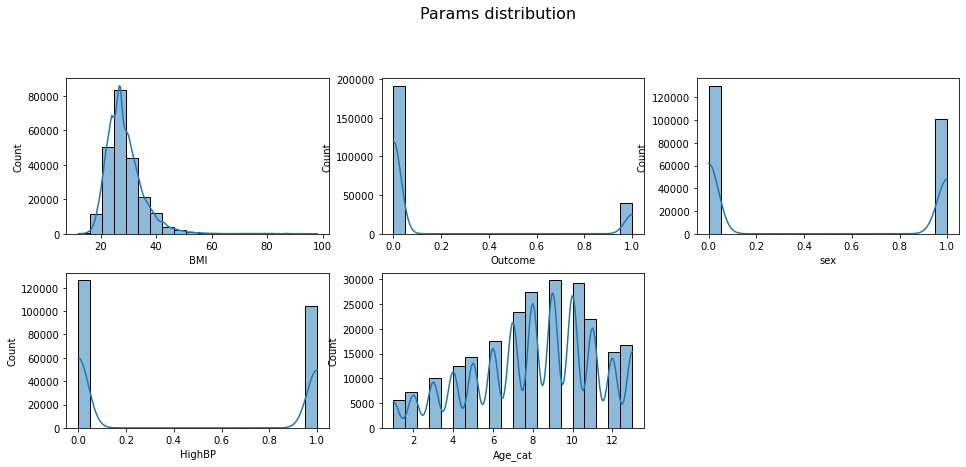

In [58]:
plot_histograms(data=diabetes_gen)

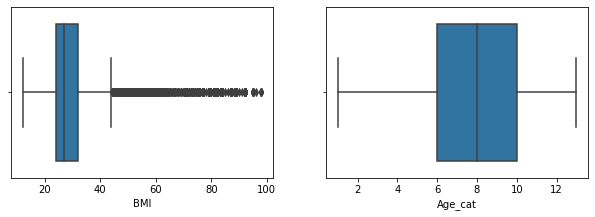

In [59]:
plot_boxplots(data=diabetes_gen.iloc[:, [0, 4]])

In [60]:
# У оставшегося числового признака проверим выбросы
outliers_table  = get_table_outliers(
    data=diabetes_gen,
    columns = ['BMI'],
    log_scales=[True]
)
display(outliers_table)

,Outliers number (3-sigm rule),Percent of outliers (%),Remain number of rows
BMI,1538.0,0.67,229797.0


Максимальное значение индекса массы тела достигает 98, что в целом реально: [список самых тяжелых людей](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D1%82%D1%8F%D0%B6%D1%91%D0%BB%D1%8B%D1%85_%D0%BB%D1%8E%D0%B4%D0%B5%D0%B9_%D0%B2_%D0%BC%D0%B8%D1%80%D0%B5)   
Эти наблюдения для нашей выборки являются выбросами, их не много, поэтому удалим их для нашего анализа. Подобные наблюдения необходимо анализировать отдельно.

In [61]:
outliers, diabetes_gen = outliers_z_score_mod(
    data=diabetes_gen,
    feature='BMI',
    log_scale=True
)

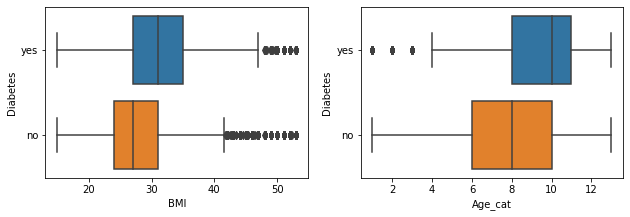

In [62]:
# Посмотрим зависимость признаков от диабета
diabetes_cat = diabetes_gen['Outcome'].apply(
    lambda x: 'yes' if x == 1 else 'no'
)
plot_boxplots(
    data=diabetes_gen.iloc[:, [0, 4]], 
    title='Diabetes', 
    cat_labels=diabetes_cat
)

Диабет чаще выявляется в старшей возрастной группе и у пациентов с более высоким индексом массы тела.  

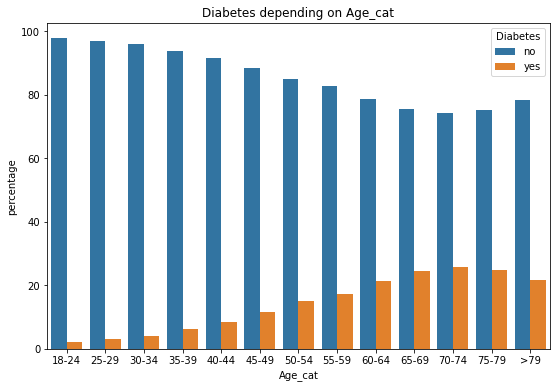

In [63]:
# Визуализируем соотношение диабета по категориям возраста
x_labels = [
    '18-24', 
    '25-29', 
    '30-34', 
    '35-39', 
    '40-44', 
    '45-49', 
    '50-54', 
    '55-59', 
    '60-64', 
    '65-69', 
    '70-74', 
    '75-79', 
    '>79'
]
plot_percentbars(
    data=diabetes_gen,
    group_feature='Age_cat',
    xticklabels=x_labels
)


Сохраняется тенденция к увеличению частоты диабета с возрастом.

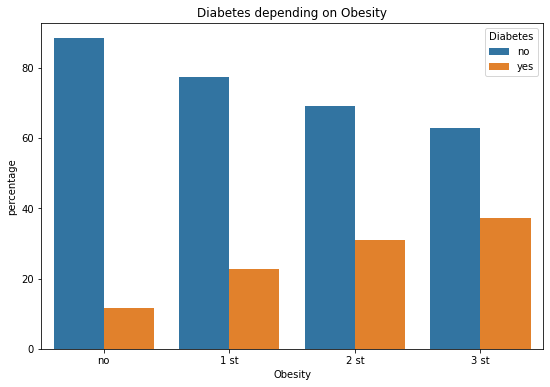

In [64]:
# Категоризуем и визуализируем индекс массы тела по степени ожирения
diabetes_gen['Obesity'] = diabetes_gen['BMI'].apply(get_obesity_stage)

plot_percentbars(
    data=diabetes_gen,
    group_feature='Obesity',
    xticklabels=['no', '1 st', '2 st', '3 st']
)

Чем выше степень ожирения, тем чаще выявляется диабет.  
  
Визуализируем зависимость бинарных признаков от диабета.

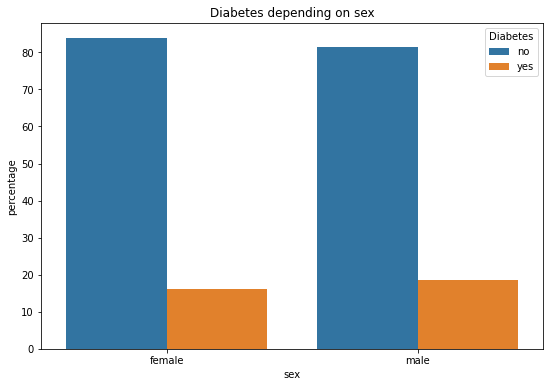

In [65]:
plot_percentbars(
    data=diabetes_gen,
    group_feature='sex',
    xticklabels=['female', 'male']
)

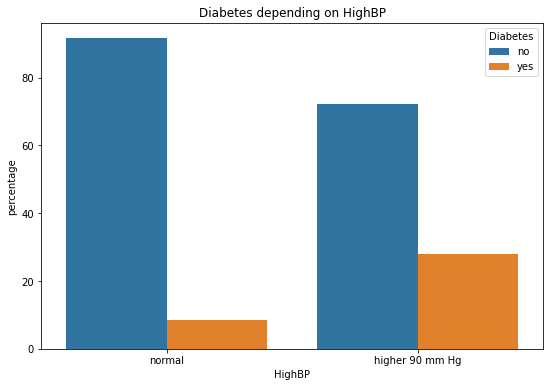

In [66]:
plot_percentbars(
    data=diabetes_gen,
    group_feature='HighBP',
    xticklabels=['normal', 'higher 90 mm Hg']
)

В общем датасете явной зависимости диабета и пола не наблюдается (нужны статистические тесты).  
Наоборот, в отличие от первого датасета у пациентов с повышенным давлением диабет выявляется чаще.  
**Вывод:** Таким образом, выявляемые нами зависимости в значительно мере зависят от конкретной анализируемой выборки пациентов.